# Equilibration detection figure generation notebook
The code was taken from [this paper](https://github.com/choderalab/automatic-equilibration-detection) and was adapted to work with python 3

In [1]:
%pylab inline
import seaborn as sbn
sbn.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})
sbn.set_style( {'font.family':'sans-serif', 'font.sans-serif':'Helvetica'})

Populating the interactive namespace from numpy and matplotlib


In [2]:
import netCDF4
import os.path

In [3]:
ncfile = netCDF4.Dataset('data.nc', 'r')
[nreplicates, niterations] = ncfile.variables['reduced_density'].shape
observation_interval = ncfile.variables['observation_interval'].getValue() # ps

# Select data to analyze.
A_it = np.array(ncfile.variables['reduced_density'][:,:], np.float64)

# Compute true expectation using mean of second half of all simulations.
t0 = int(niterations/2)
true_expectation = A_it[:,t0:].mean(1).mean(0)

#
# PLOT RELAXATION OF REDUCED DENSITIES
#

# Write initial reduced densities.
print ("Initial reduced densities:")
print (A_it[0,0])

x = np.arange(niterations) # tau
A_t = A_it.mean(0)
dA_t = A_it.std(0)


Initial reduced densities:
0.9599999785423279


## Figure A

In [4]:
nskip = 10 # number of samples to skip in uncertainty shading
nmax = 4000 # maximum samples to show
fontsize = 15

In [5]:
ncfile = netCDF4.Dataset('data.nc', 'r')
[nreplicates, niterations] = ncfile.variables['reduced_potential'].shape
observation_interval = ncfile.variables['observation_interval'].getValue() # ps

In [6]:
# Select data to analyze.
A_it = np.array(ncfile.variables['reduced_potential'][:,:], np.float64)

# Compute true expectation using mean of second half of all simulations.
t0 = int(niterations/2)
true_expectation = A_it[:,t0:].mean(1).mean(0)

#
# PLOT RELAXATION OF REDUCED DENSITIES
#



x = np.arange(niterations) # tau
A_t = A_it.mean(0)
dA_t = A_it.std(0)

[]

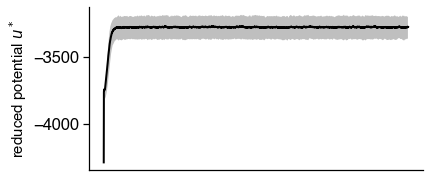

In [7]:
figsize(6,3)
fig, ax = plt.subplots()
pylab.fill_between(x[:nmax:nskip], A_t[:nmax:nskip]+2*dA_t[:nmax:nskip], A_t[:nmax:nskip]-2*dA_t[:nmax:nskip], facecolor='grey', edgecolor='grey', alpha=0.5, linewidth=0)
pylab.plot(x[:nmax], A_t[:nmax], 'k-')

pylab.ylabel(r'reduced potential $u^*$', fontsize=fontsize)
sbn.despine()
ax.set_xticks([])

## Figure B

In [8]:
Nequil = 100
Acumavg_it = np.zeros([nreplicates, niterations], np.float64)
Aburnin_it = np.zeros([nreplicates, niterations], np.float64)
for i in range(nreplicates):
    for t in range(niterations):
        Acumavg_it[i,t] = A_it[i,0:(t+1)].mean()

        Ninit = Nequil
        if t < Nequil:
            Ninit = 0
        Aburnin_it[i,t] = A_it[i,Ninit:(t+1)].mean()

# Compute reverse cumulative average.
Arevcum_it = np.zeros([nreplicates, niterations], np.float64)
for i in range(nreplicates):
    for t0 in range(niterations):
        Arevcum_it[i,t0] = A_it[i,t0:].mean()

Acumavg_mean_t = Acumavg_it.mean(0)
Aburnin_mean_t = Aburnin_it.mean(0)
Arevcum_mean_t = Arevcum_it.mean(0)

Acumavg_std_t = Acumavg_it.std(0)
Aburnin_std_t = Aburnin_it.std(0)
Arevcum_std_t = Arevcum_it.std(0)

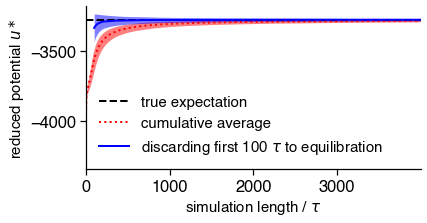

In [10]:

fontsize = 15
pylab.fill_between(x[:nmax:nskip], Acumavg_mean_t[:nmax:nskip]+2*Acumavg_std_t[:nmax:nskip], Acumavg_mean_t[:nmax:nskip]-2*Acumavg_std_t[:nmax:nskip], facecolor='red', edgecolor='red', alpha=0.5, linewidth=0)
pylab.fill_between(x[Nequil:nmax:nskip], Aburnin_mean_t[Nequil:nmax:nskip]+2*Aburnin_std_t[Nequil:nmax:nskip], Aburnin_mean_t[Nequil:nmax:nskip]-2*Aburnin_std_t[Nequil:nmax:nskip], facecolor='blue', edgecolor='blue', alpha=0.5, linewidth=0)

pylab.plot([x[0], x[nmax]], [true_expectation, true_expectation], 'k--') # true expectation (from all data)
pylab.plot(x[:nmax], Acumavg_mean_t[:nmax], 'r:') # cumulative average from beginning
pylab.plot(x[Nequil:nmax], Aburnin_mean_t[Nequil:nmax], 'b-') # cumulative average after discarding some initial data to equilibrium

pylab.legend(['true expectation', 'cumulative average', r'discarding first %d $\tau$ to equilibration' % Nequil], fontsize=fontsize, frameon=False)

pylab.xlabel(r'simulation length / $\tau$', fontsize=15)
pylab.ylabel(r'reduced potential $u*$', fontsize=15)

# Adjust axes.
oldaxis = pylab.axis()
pylab.axis([0, x[:nmax].max(), oldaxis[2], oldaxis[3]])

sbn.despine()

## Figure C

In [13]:
t0max = 1001 # largest number of initial samples to discard
tmax = 2000 # total trajectory length to include in analysis

In [14]:
from equilibration import statisticalInefficiency_multiscale as statisticalInefficiency

In [15]:
# Compute integrated autocorrelation times.
print ("Computing integrated autocorrelation times for all initial equilibration times t0...")
g_it = np.zeros([nreplicates,t0max], np.float64)
for replicate in range(nreplicates):
    print ("replicate %d / %d..." % (replicate, nreplicates))
    for t0 in range(t0max):
        A_t = np.squeeze(A_it[replicate, t0:tmax])
        g_it[replicate,t0] = statisticalInefficiency(A_t)

# Compute effective number of uncorrelated samples.
print ("Computing effective number of uncorrelated samples...")
N_it = np.zeros([nreplicates,t0max], np.float64)
for replicate in range(nreplicates):
    print ("replicate %d / %d..." % (replicate, nreplicates))
    for t0 in range(t0max):
        N_it[replicate,t0] = (tmax-t0+1) / g_it[replicate,t0]

# Determine optimal equilibration end (t0equil) by maximum number of effective samples (max of Neff).
t0equil = np.argmax(N_it.mean(0))
print ("t0equil = %d" % t0equil)

# Determine individual t0equil points.
print ("Determining optimal equilibration times for each trajectory...")
t0equil_i = np.zeros([nreplicates], np.int32)
for replicate in range(nreplicates):
    t0equil_i[replicate] = np.argmax(N_it[replicate,:])

# Determine mean as a function of initial t0.
tbvmax = tmax - 200
Aburnin_it = np.zeros([nreplicates, tbvmax], np.float64)
Astderr_it = np.zeros([nreplicates, tbvmax], np.float64)
for i in range(nreplicates):
    for t0 in range(tbvmax):
        A_t = np.squeeze(A_it[i, t0:tmax])
        g = statisticalInefficiency(A_t)
        Aburnin_it[i,t0] = A_t.mean()
        Astderr_it[i,t0] = A_t.std() / np.sqrt((tmax-t0+1) / g)

Aburnin_mean_t = Aburnin_it.mean(0)
Aburnin_std_t  = Aburnin_it.std(0)

# Compute bias/variance tradeoff for fixed initial burn-in times.
Abias_mean_t = Aburnin_it.mean(0) - true_expectation
Abias_stderr_t = Aburnin_it.mean(0) / np.sqrt(nreplicates)
Astderr_mean_t = Aburnin_it.std(0)
Astderr_stderr_t = Aburnin_it.std(0) / np.sqrt(nreplicates)

# Compute estimates bias and variance using no equilibration, arbitrary equilibration, and optimal equilibration.
bias_i = dict()
stddev_i = dict()
schemes = ['noequil', 'optequil', 'fixedequil']
for scheme in schemes:
    bias_i[scheme] = np.zeros([nreplicates], np.float64)
    stddev_i[scheme] = np.zeros([nreplicates], np.float64)

for replicate in range(nreplicates):
    for scheme in schemes:
        if scheme == 'noequil':
            t0 = 0
        elif scheme == 'optequil':
            t0 = t0equil_i[replicate]
        elif scheme == 'fixedequil':
            t0 = t0equil
        else:
            raise Exception("scheme '%s' unknown" % scheme)

        # Extract timeseries for desired equilibration time t0.
        A_t = np.squeeze(A_it[replicate, t0:tmax])
        N = len(A_t)
        g = g_it[replicate, t0]
        # Compute statistics of estimate.
        bias_i[scheme][replicate] = A_t.mean() - true_expectation
        stddev_i[scheme][replicate] = A_t.std() / np.sqrt(N/g)

# Summarize error, bias, and variance statistics for different equilibration time selection schemes.
print ("")
print ("STATISTICS")
for scheme in schemes:
    # Compute RMSE and dRMSE for this scheme.
    B = ((bias_i[scheme][:])**2).mean(0)
    dB = ((bias_i[scheme][:])**2).std(0) / np.sqrt(nreplicates)
    rmse = np.sqrt(B)
    drmse = 0.5 * dB / rmse

    #print ("%24s : error %10.6f +- %10.6f | bias %10.6f +- %10.6f | stddev %10.6f +- %10.6f" % (scheme, rmse, drmse, bias_i[scheme].mean(), bias_i[scheme].std()/np.sqrt(nreplicates), stddev_i[scheme].mean(), stddev_i[scheme].std()/np.sqrt(nreplicates)))

Computing integrated autocorrelation times for all initial equilibration times t0...
replicate 0 / 500...
replicate 1 / 500...
replicate 2 / 500...
replicate 3 / 500...
replicate 4 / 500...
replicate 5 / 500...
replicate 6 / 500...
replicate 7 / 500...
replicate 8 / 500...
replicate 9 / 500...
replicate 10 / 500...
replicate 11 / 500...
replicate 12 / 500...
replicate 13 / 500...
replicate 14 / 500...
replicate 15 / 500...
replicate 16 / 500...
replicate 17 / 500...
replicate 18 / 500...
replicate 19 / 500...
replicate 20 / 500...
replicate 21 / 500...
replicate 22 / 500...
replicate 23 / 500...
replicate 24 / 500...
replicate 25 / 500...
replicate 26 / 500...
replicate 27 / 500...
replicate 28 / 500...
replicate 29 / 500...
replicate 30 / 500...
replicate 31 / 500...
replicate 32 / 500...
replicate 33 / 500...
replicate 34 / 500...
replicate 35 / 500...
replicate 36 / 500...
replicate 37 / 500...
replicate 38 / 500...
replicate 39 / 500...
replicate 40 / 500...
replicate 41 / 500...
r

replicate 358 / 500...
replicate 359 / 500...
replicate 360 / 500...
replicate 361 / 500...
replicate 362 / 500...
replicate 363 / 500...
replicate 364 / 500...
replicate 365 / 500...
replicate 366 / 500...
replicate 367 / 500...
replicate 368 / 500...
replicate 369 / 500...
replicate 370 / 500...
replicate 371 / 500...
replicate 372 / 500...
replicate 373 / 500...
replicate 374 / 500...
replicate 375 / 500...
replicate 376 / 500...
replicate 377 / 500...
replicate 378 / 500...
replicate 379 / 500...
replicate 380 / 500...
replicate 381 / 500...
replicate 382 / 500...
replicate 383 / 500...
replicate 384 / 500...
replicate 385 / 500...
replicate 386 / 500...
replicate 387 / 500...
replicate 388 / 500...
replicate 389 / 500...
replicate 390 / 500...
replicate 391 / 500...
replicate 392 / 500...
replicate 393 / 500...
replicate 394 / 500...
replicate 395 / 500...
replicate 396 / 500...
replicate 397 / 500...
replicate 398 / 500...
replicate 399 / 500...
replicate 400 / 500...
replicate 4

replicate 251 / 500...
replicate 252 / 500...
replicate 253 / 500...
replicate 254 / 500...
replicate 255 / 500...
replicate 256 / 500...
replicate 257 / 500...
replicate 258 / 500...
replicate 259 / 500...
replicate 260 / 500...
replicate 261 / 500...
replicate 262 / 500...
replicate 263 / 500...
replicate 264 / 500...
replicate 265 / 500...
replicate 266 / 500...
replicate 267 / 500...
replicate 268 / 500...
replicate 269 / 500...
replicate 270 / 500...
replicate 271 / 500...
replicate 272 / 500...
replicate 273 / 500...
replicate 274 / 500...
replicate 275 / 500...
replicate 276 / 500...
replicate 277 / 500...
replicate 278 / 500...
replicate 279 / 500...
replicate 280 / 500...
replicate 281 / 500...
replicate 282 / 500...
replicate 283 / 500...
replicate 284 / 500...
replicate 285 / 500...
replicate 286 / 500...
replicate 287 / 500...
replicate 288 / 500...
replicate 289 / 500...
replicate 290 / 500...
replicate 291 / 500...
replicate 292 / 500...
replicate 293 / 500...
replicate 2

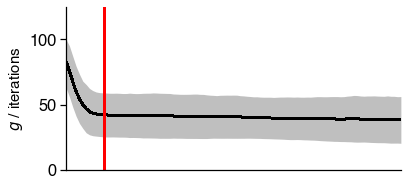

In [17]:
fontsize=15
figsize(6,3)
fig, ax = plt.subplots()
pylab.fill_between(x[0:t0max:nskip], g_it[:,0:t0max:nskip].mean(0)+g_it[:,0:t0max:nskip].std(0), g_it[:,0:t0max:nskip].mean(0)-g_it[:,0:t0max:nskip].std(0), facecolor='gray', edgecolor='gray', alpha=0.5, linewidth=0)
pylab.plot(np.tile(x[0:t0max], [nreplicates,1]).T, g_it[:,:t0max].mean(0), 'k-')

ax.set_xticks([]) # no x-tick labels
# Adjust axes.
oldaxis = pylab.axis()
oldaxis = (oldaxis[0], oldaxis[1], 0, 125)
pylab.axis([0, x[:t0max].max(), oldaxis[2], oldaxis[3]])

# Plot t0equil.
pylab.plot(x[t0equil]*np.array([1,1]), [oldaxis[2], oldaxis[3]], 'r-', linewidth=3)

pylab.plot(x[t0equil]*np.array([1,1]), [oldaxis[2], oldaxis[3]], 'r-', linewidth=3)

plt.ylabel(r'$g$ / iterations', fontsize=fontsize)
sbn.despine()

## Figure D

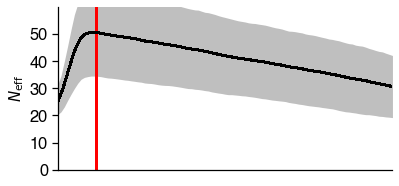

In [18]:
figsize(6,3)
fig, ax = plt.subplots()
oldaxis = pylab.axis()
oldaxis = (oldaxis[0], oldaxis[1], 0, 60)
pylab.axis([0, x[:t0max].max(), oldaxis[2], oldaxis[3]])

pylab.plot(x[t0equil]*np.array([1,1]), [oldaxis[2], oldaxis[3]], 'r-', linewidth=3)

plt.fill_between(x[0:t0max:nskip], N_it[:,0:t0max:nskip].mean(0)+N_it[:,0:t0max:nskip].std(0), N_it[:,0:t0max:nskip].mean(0)-N_it[:,0:t0max:nskip].std(0), facecolor='gray', edgecolor='gray', alpha=0.5, linewidth=0)
plt.plot(np.tile(x[0:t0max], [nreplicates,1]).T, N_it[:,:t0max].mean(0), 'k-')

ax.set_xticks([]) # no x-tick labels

pylab.ylabel(r'$N_\mathrm{eff}$', fontsize=fontsize)

pylab.axis([0, x[:t0max].max(), oldaxis[2], oldaxis[3]])
ax.set_yticks([0, 10, 20, 30, 40, 50])
sbn.despine()

## Figure E

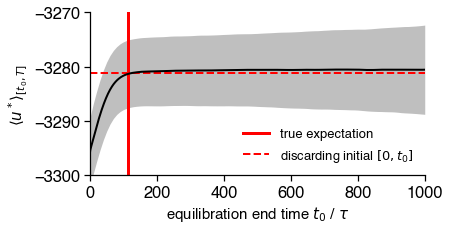

In [19]:
# Plot t0equil.
# Adjust axes.
oldaxis = pylab.axis()
oldaxis = (oldaxis[0], oldaxis[1], -3300, -3270)
pylab.axis([0, x[:t0max].max(), oldaxis[2], oldaxis[3]])
pylab.plot(x[t0equil]*np.array([1,1]), [oldaxis[2], oldaxis[3]], 'r-', linewidth=3)

pylab.fill_between(x[0:t0max:nskip], Aburnin_mean_t[0:t0max:nskip]+Aburnin_std_t[0:t0max:nskip], Aburnin_mean_t[0:t0max:nskip]-Aburnin_std_t[0:t0max:nskip], facecolor='gray', edgecolor='gray', alpha=0.5, linewidth=0)
pylab.plot([x[0], x[t0max]], [true_expectation, true_expectation], 'r--')
pylab.plot(x[0:t0max], Aburnin_mean_t[0:t0max], 'k-')

pylab.legend(['true expectation', 'discarding initial $[0,t_0]$'], fontsize=fontsize-2, frameon=False, loc='lower right')

pylab.xlabel(r'equilibration end time $t_0$ / $\tau$', fontsize=fontsize)
pylab.ylabel(r'$\left\langle u^*\right\rangle_{[t_0,T]}$', fontsize=fontsize)
sbn.despine()